In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
import numpy as np
from itertools import tee
from gui.user_code import pairwise_randomised_significance, get_data_for_signif_test
from gui.output_utils import get_cv_fold_count, get_cv_scores_many_experiment
from gui.constants import CLASSIFIER

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


# Does the classification evaluation framework work?
What is the effect of adding uniform random noise to vectors? Can our experiments tell between a set of vectors and a corrupted version of the same vectors? To find out, add uniform random noise from $-n$ to $n$ (x axis) to all non-zero entries in a set of `word2vec` embeddings.
     

In [10]:
def plot(d):
    experiments = Experiment.objects.filter(**d).order_by('expansions__noise')
    e = [x.id for x in experiments if x.expansions.entries_of is None]
    print('experiments are', e)

    for eid in e:
        print('id %d noise %2.2f, acc %2.2f, macrof1 %2.2f'%(eid,
                                              Experiment.objects.get(id=eid).expansions.noise,
                                              Results.objects.get(id=eid, classifier=CLASSIFIER).accuracy_mean,
                                              Results.objects.get(id=eid, classifier=CLASSIFIER).macrof1_mean))

    df = dataframe_from_exp_ids(e, {'noise':'expansions__noise'})
    df['noise'] = ['%1.1f'%float(x) for x in df.noise]
    df.to_html('tmp.html')
#     ax = sns.factorplot(x='noise', y='Accuracy', data=df, kind='point', aspect=1.5);
    ax = sns.tsplot(df, time='noise', value='Accuracy', unit='folds', marker='o')
#     ax.set_xlabels('')

    # random baseline for comparison
    plt.axhline(random_vect_baseline(corpus=d['labelled']), c='k')
    return df

experiments are [34, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
id 34 noise 0.00, acc 0.53, macrof1 0.49
id 99 noise 0.20, acc 0.45, macrof1 0.41
id 100 noise 0.40, acc 0.48, macrof1 0.43
id 101 noise 0.60, acc 0.45, macrof1 0.41
id 102 noise 0.80, acc 0.39, macrof1 0.34
id 103 noise 1.00, acc 0.35, macrof1 0.31
id 104 noise 1.20, acc 0.30, macrof1 0.26
id 105 noise 1.40, acc 0.29, macrof1 0.25
id 106 noise 1.60, acc 0.26, macrof1 0.23
id 107 noise 1.80, acc 0.26, macrof1 0.23
id 108 noise 2.00, acc 0.24, macrof1 0.21
Accuracy has 5500 values
folds has 5500 values
noise has 5500 values


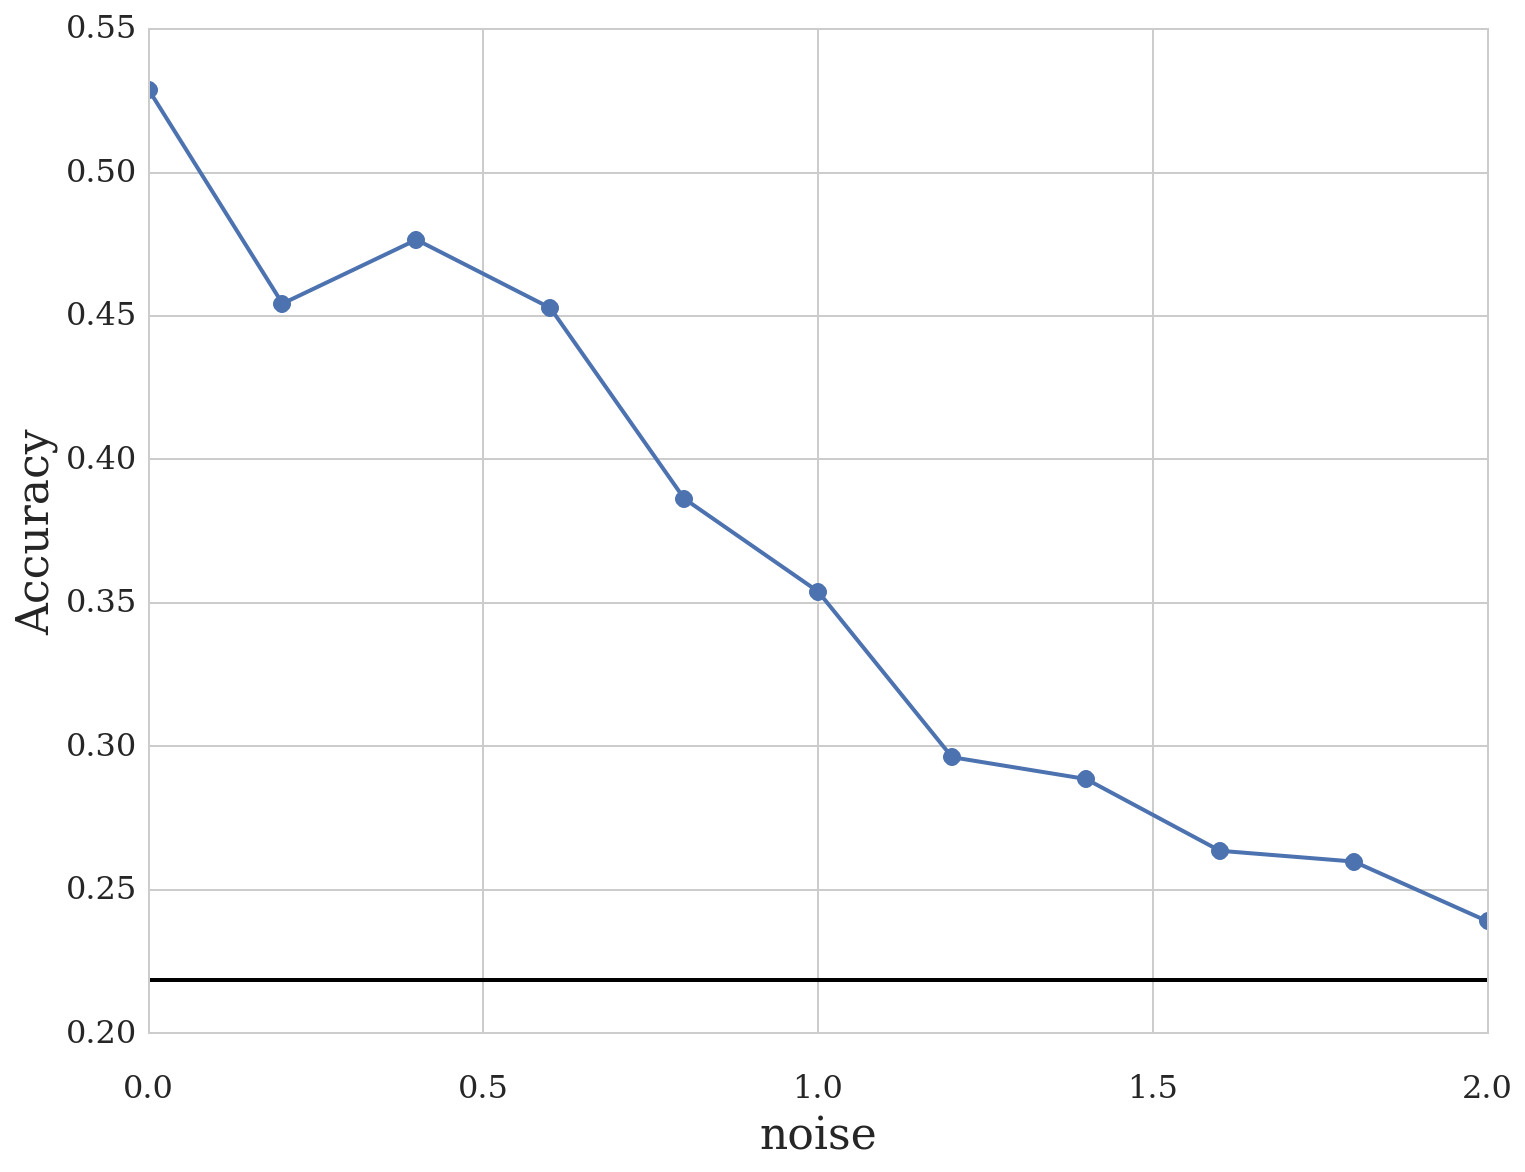

In [11]:
d = {'expansions__vectors__unlabelled_percentage': 100,
     'labelled': 'amazon_grouped-tagged',
     'expansions__vectors__dimensionality': 100,
     'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
     'expansions__vectors__composer': 'Add',
     'expansions__vectors__rep': 0, 
     'expansions__allow_overlap': False,
     'expansions__k': 3,
     'expansions__vectors__unlabelled': 'wiki',
     'expansions__vectors__algorithm': 'word2vec',
     'document_features_tr': 'J+N+AN+NN',
     'document_features_ev': 'AN+NN',
     'labelled': 'amazon_grouped-tagged'}
df = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Question
In thesis `v0.13` this graph didn't look right (Figure 8). 

experiments are [163, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206]
id 163 noise 0.00, acc 0.66, macrof1 0.62
id 197 noise 0.20, acc 0.67, macrof1 0.65
id 198 noise 0.40, acc 0.58, macrof1 0.54
id 199 noise 0.60, acc 0.49, macrof1 0.38
id 200 noise 0.80, acc 0.59, macrof1 0.55
id 201 noise 1.00, acc 0.49, macrof1 0.37
id 202 noise 1.20, acc 0.48, macrof1 0.36
id 203 noise 1.40, acc 0.51, macrof1 0.41
id 204 noise 1.60, acc 0.48, macrof1 0.35
id 205 noise 1.80, acc 0.52, macrof1 0.41
id 206 noise 2.00, acc 0.50, macrof1 0.39
Accuracy has 5500 values
folds has 5500 values
noise has 5500 values


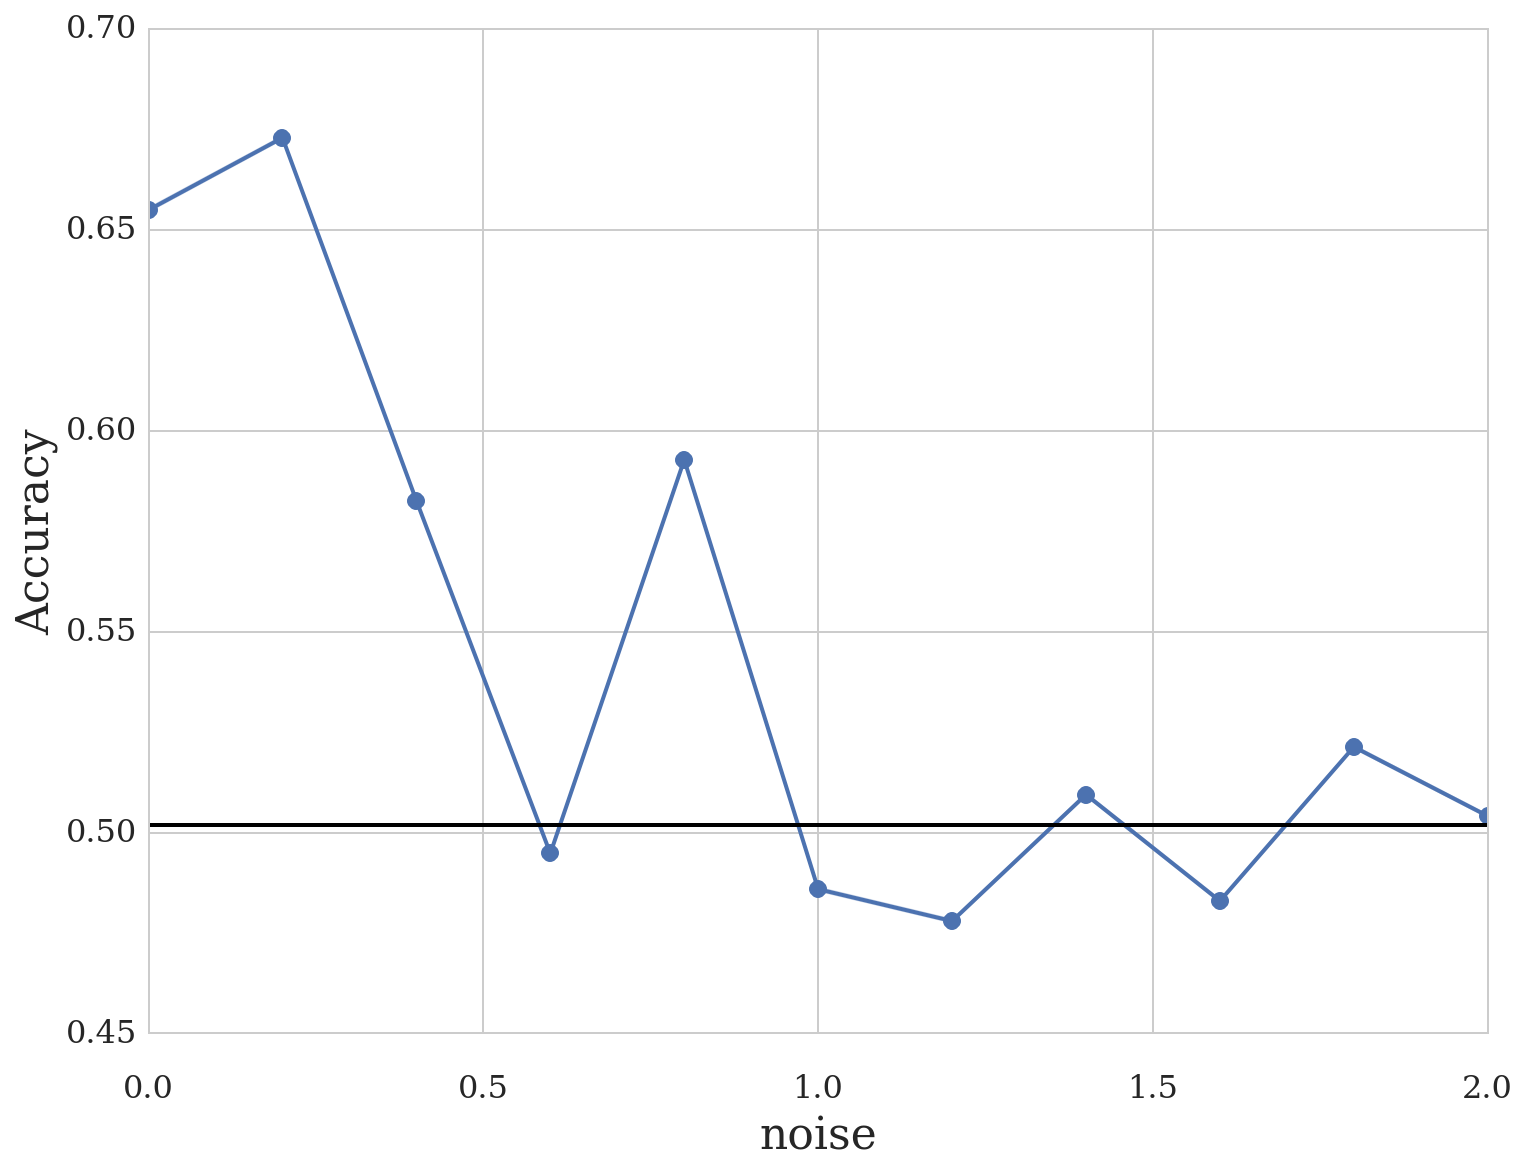

In [12]:
d['labelled'] = 'reuters21578/r8-tagged-grouped'
df2 = plot(d).convert_objects(convert_numeric=True)
plt.savefig('plot-noise-gigaword-add-r2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)